# _Moneyballing Fantasy Premier League Football_
# Decision Trees

We've finally brough the data together ready for modelling!

If we consider the different approaches and algorithms, it's clear that parametric methods (such as linear regression) are not going to be appropriate. There are too many assumptions that we know aren't going to be met (some of our features are subsets of each other, for example), so we should jump straight to non-parametric methods, starting with the humble decision tree.

### Bringing in the required libraries...

In [1]:
#Standard data manipulations
import pandas as pd
import numpy as np

#For data pre-processing
from sklearn.model_selection import train_test_split

#For decision trees/random forests
from sklearn.tree import DecisionTreeRegressor

#Grid searching
from sklearn.model_selection import GridSearchCV

#Model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#Data visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#Import custom visuals settings
from PythonFunctions.cb91visuals import *

#Pickle!
import pickle

#Suppress warnings from showing
import warnings
warnings.filterwarnings('ignore')

... and the data

In [2]:
features = pd.read_csv('Data/Datasets/df_features_p.csv', index_col='Unnamed: 0')
y = pd.read_csv('Data/Datasets/df_targets_p.csv', index_col='Unnamed: 0')

XG = y['XG']
XA = y['XA']
XGI = y['XGI']

#Create test/train splits as required
X_train_XG, X_test_XG, y_train_XG, y_test_XG = train_test_split(features,XG,random_state=20)
X_train_XA, X_test_XA, y_train_XA, y_test_XA = train_test_split(features,XG,random_state=30)
X_train_XGI, X_test_XGI, y_train_XGI, y_test_XGI = train_test_split(features,XG,random_state=10)

## Vanilla Trees

Let's get straight to a vanilla version of the sklearn tree, and see how it does.

In [3]:
XG_model_1 = DecisionTreeRegressor()
XG_model_1.fit(X_train_XG, y_train_XG)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

We need some ways to test the effectiveness of this model.

In [18]:
def adj_r2(y_true, y_pred, n_feat=len(features.columns)):
    '''
    Takes true ys, predicted ys, the number of samples,
    and the number of variables.
    Calculates adjusted r squared
    '''
    n_samp = len(y_true)
    
    #Calculate regular r2
    R2 = r2_score(y_true, y_pred)
    
    #Return adjusted rsquared
    return 1-(1-R2)*(n_samp-1)/(n_samp-n_feat-1)



def plot_model(y_true, y_pred, title=None, size=(6,6)):
    '''
    Plots y_true against y_pred
    '''
    #Plot the scatter
    plt.figure(figsize=size)
    plt.scatter(y_true, y_pred, s=10, alpha=0.5)
    
    #Plot x=y
    max_val = max([y_true.max(), y_pred.max()])
    plt.plot([0,max_val],[0,max_val],color='red',lw=1,ls='--')

    plt.xlim(0)
    plt.ylim(0)

    plt.xlabel('Actual')
    plt.ylabel('Prediction')
    plt.title(title);
    


def performance(model, X_train, X_test, y_train, y_test, size=(4,4)):
    
    y_hat_train = model.predict(X_train)
    y_hat_test = model.predict(X_test)
    
    print('\n_________R2_________\n')
    print('Train R2:', round(r2_score(y_train, y_hat_train),4))
    print('Test R2:', round(r2_score(y_test, y_hat_test),4))
    print('\nTrain Adj R2:', round(adj_r2(y_train, y_hat_train),4))
    print('Test Adj R2:', round(adj_r2(y_test, y_hat_test),4))
    
    print('\n_________MSE________\n')
    print('Train MSE:', round(mean_squared_error(y_train, y_hat_train),4))
    print('Test MSE:', round(mean_squared_error(y_test, y_hat_test),4))
    print('\nTrain RMSE:', round(mean_squared_error(y_train, y_hat_train)**0.5,4))
    print('Test RMSE:', round(mean_squared_error(y_test, y_hat_test)**0.5,4))

    plot_model(y_train, y_hat_train, title='Training Set', size=size)
    
    plot_model(y_test, y_hat_test, title='Test Set', size=size)

Let's test out this performance function...


_________R2_________

Train R2: 1.0
Test R2: -0.5387

Train Adj R2: 1.0
Test Adj R2: -0.6511

_________MSE________

Train MSE: 0.0
Test MSE: 0.1498

Train RMSE: 0.0
Test RMSE: 0.387


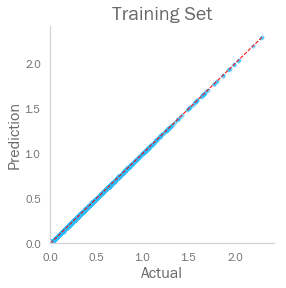

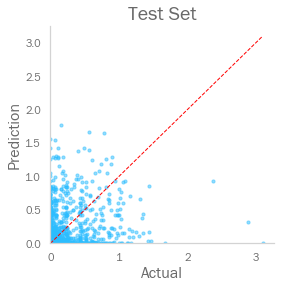

In [19]:
performance(XG_model_1, X_train_XG, X_test_XG, y_train_XG, y_test_XG)

So we can see that this model has massively overfit. We can only assume that it'll do the same to the 'goal involvement' metric.


_________R2_________

Train R2: 1.0
Test R2: -0.558

Train Adj R2: 1.0
Test Adj R2: -0.6718

_________MSE________

Train MSE: 0.0
Test MSE: 0.1438

Train RMSE: 0.0
Test RMSE: 0.3793


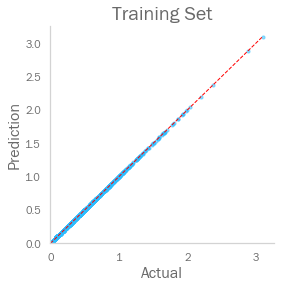

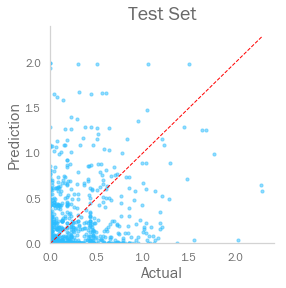

In [20]:
XA_model_1 = DecisionTreeRegressor()
XA_model_1.fit(X_train_XA, y_train_XA)
performance(XA_model_1, X_train_XA, X_test_XA, y_train_XA, y_test_XA)


_________R2_________

Train R2: 1.0
Test R2: -0.9664

Train Adj R2: 1.0
Test Adj R2: -1.11

_________MSE________

Train MSE: 0.0
Test MSE: 0.1527

Train RMSE: 0.0
Test RMSE: 0.3907


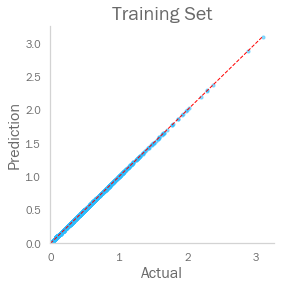

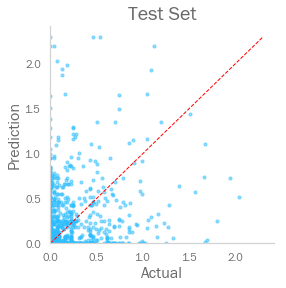

In [21]:
XGI_model_1 = DecisionTreeRegressor()
XGI_model_1.fit(X_train_XGI, y_train_XGI)
performance(XGI_model_1, X_train_XGI, X_test_XGI, y_train_XGI, y_test_XGI)

## Gridsearching

These trees are massively overfitting on pretty much each target. Can we tune hyperparameters to do better?

In [22]:
regressor = DecisionTreeRegressor()

#Create a parameter grid, and run it through the GridSearch class
param_grid = {
    "criterion": ['mse', 'friedman_mse', 'mae'],
    "max_depth": [3,5,7,10,None],
    "min_samples_split": [2,4,6,8,10],
    "max_features": ['auto','log2']
}


XG_GS = GridSearchCV(regressor, param_grid, cv=5, n_jobs=-1,
                      scoring='r2', verbose=True)

# XG_GS.fit(X_train_XG, y_train_XG)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:  8.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeRegressor(criterion='mse', max_depth=None,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False, random_state=None,
                                             splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'criterion': ['mse', 'friedman_mse', 'mae'],
                         'max_depth': [3, 5, 7, 10, None],
                         'max_features': ['auto', 'log2'],
                         '

In [24]:
# with open('Models/XG_GS.pickle', 'wb') as f:
#     pickle.dump(XG_GS, f, pickle.HIGHEST_PROTOCOL)

with open('Models/XG_GS.pickle', 'rb') as f:
    XG_GS = pickle.load(f)

{'criterion': 'friedman_mse', 'max_depth': 3, 'max_features': 'log2', 'min_samples_split': 8} 


_________R2_________

Train R2: 0.1748
Test R2: 0.1757

Train Adj R2: 0.1556
Test Adj R2: 0.1155

_________MSE________

Train MSE: 0.081
Test MSE: 0.0802

Train RMSE: 0.2845
Test RMSE: 0.2833


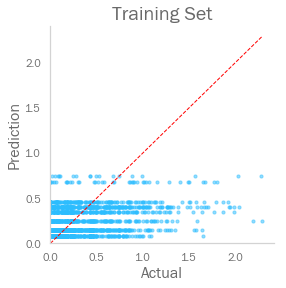

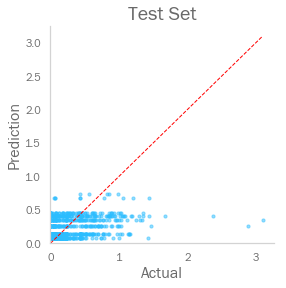

In [23]:
print(XG_GS.best_params_, '\n')
XG_model_2 = XGI_GS.best_estimator_
performance(XG_model_2, X_train_XG, X_test_XG, y_train_XG, y_test_XG)

In [26]:
regressor = DecisionTreeRegressor()

#Create a parameter grid, and run it through the GridSearch class
param_grid = {
    "criterion": ['mse', 'friedman_mse', 'mae'],
    "max_depth": [3,5,7,10,None],
    "min_samples_split": [2,4,6,8,10],
    "max_features": ['auto','log2']
}


XGI_GS = GridSearchCV(regressor, param_grid, cv=5, n_jobs=-1,
                      scoring='neg_mean_squared_error', verbose=True)

XGI_GS.fit(X_train_XGI, y_train_XGI)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:  7.5min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeRegressor(criterion='mse', max_depth=None,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False, random_state=None,
                                             splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'criterion': ['mse', 'friedman_mse', 'mae'],
                         'max_depth': [3, 5, 7, 10, None],
                         'max_features': ['auto', 'log2'],
                         '

{'criterion': 'friedman_mse', 'max_depth': 3, 'max_features': 'log2', 'min_samples_split': 4} 


_________R2_________

Train R2: 0.2105
Test R2: 0.1391

Train Adj R2: 0.1922
Test Adj R2: 0.0762

_________MSE________

Train MSE: 0.0824
Test MSE: 0.0668

Train RMSE: 0.287
Test RMSE: 0.2585


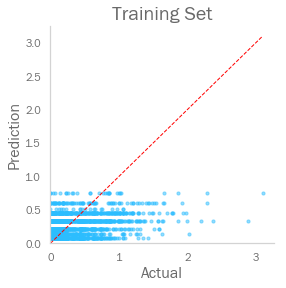

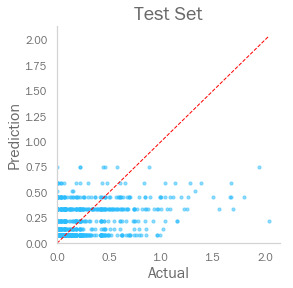

In [27]:
print(XGI_GS.best_params_, '\n')
XGI_model_2 = XGI_GS.best_estimator_
performance(XGI_model_2, X_train_XGI, X_test_XGI, y_train_XGI, y_test_XGI)

Regardless of exactly what we're measuring, it's clear that the trees are struggling badly - mostly due to a tendency to overfit.